In [10]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv("Walmart.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [12]:
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [13]:
df_model = df.copy()

df_model['year'] = df_model['Date'].dt.year
df_model['month'] = df_model['Date'].dt.month
df_model['week'] = df_model['Date'].dt.isocalendar().week.astype(int)
df_model['Quarter'] = df_model['Date'].dt.quarter

df_model = df_model.sort_values('Date')
df_model['Trend'] = np.arange(1, len(df)+1)

df_model['Rolling_mean_5'] = df_model['Weekly_Sales'].rolling(window=5).mean().shift(1)
df_model['Rolling_mean_10'] = df_model['Weekly_Sales'].rolling(window=10).mean().shift(1)

df_model['Lag_1'] = df_model['Weekly_Sales'].shift(1)
df_model['Lag_2'] = df_model['Weekly_Sales'].shift(2)

# Use bfill() directly instead of the deprecated fillna(method='bfill')
df_model.bfill(inplace=True)

print("Feature Engineering Completed Successfully!")
print(f"Shape after feature creation: {df_model.shape}")
df_model.head()

Feature Engineering Completed Successfully!
Shape after feature creation: (6435, 17)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,week,Quarter,Trend,Rolling_mean_5,Rolling_mean_10,Lag_1,Lag_2
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,1,1,1125378.184,1159822.43,1643690.90,1643690.90
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765,2010,2,5,1,2,1125378.184,1159822.43,1643690.90,1643690.90
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554,2010,2,5,1,3,1125378.184,1159822.43,2193048.75,1643690.90
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548,2010,2,5,1,4,1125378.184,1159822.43,536006.73,2193048.75
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324,2010,2,5,1,5,1125378.184,1159822.43,789036.02,536006.73


In [14]:
df_model['Weekly_Sales_detrend'] = df_model['Lag_1'] - df_model['Rolling_mean_5']

In [15]:
def _normalize_expanding(s):
    mins = s.expanding().min()
    maxs = s.expanding().max()
    denom = (maxs - mins).replace(0, np.nan)
    return ((s - mins) / denom).shift(1).fillna(0)

df_model['Weekly_Sales_Norm'] = df_model.groupby('Store')['Weekly_Sales_detrend'].apply(_normalize_expanding).reset_index(level=0, drop=True)

In [16]:
df_model

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,week,Quarter,Trend,Rolling_mean_5,Rolling_mean_10,Lag_1,Lag_2,Weekly_Sales_detrend,Weekly_Sales_Norm
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,1,1,1125378.184,1159822.430,1643690.90,1643690.90,518312.716,0.000000
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765,2010,2,5,1,2,1125378.184,1159822.430,1643690.90,1643690.90,518312.716,0.000000
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554,2010,2,5,1,3,1125378.184,1159822.430,2193048.75,1643690.90,1067670.566,0.000000
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548,2010,2,5,1,4,1125378.184,1159822.430,536006.73,2193048.75,-589371.454,0.000000
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324,2010,2,5,1,5,1125378.184,1159822.430,789036.02,536006.73,-336342.164,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3574,25,2012-10-26,688940.94,0,56.69,3.882,216.151590,7.293,2012,10,43,4,6431,1203328.820,1158276.411,2031650.55,1704357.62,828321.730,0.540036
714,5,2012-10-26,319550.77,0,71.70,3.506,224.037814,5.422,2012,10,43,4,6432,1260030.468,1117728.236,688940.94,2031650.55,-571089.528,0.216252
5719,40,2012-10-26,921264.52,0,49.65,3.917,138.728161,4.145,2012,10,43,4,6433,1216946.486,1014937.854,319550.77,688940.94,-897395.716,0.320941
2573,18,2012-10-26,1127516.25,0,56.09,3.917,138.728161,8.243,2012,10,43,4,6434,1133152.880,1055588.698,921264.52,319550.77,-211888.360,0.308674


<Axes: xlabel='Date', ylabel='Weekly_Sales_Norm'>

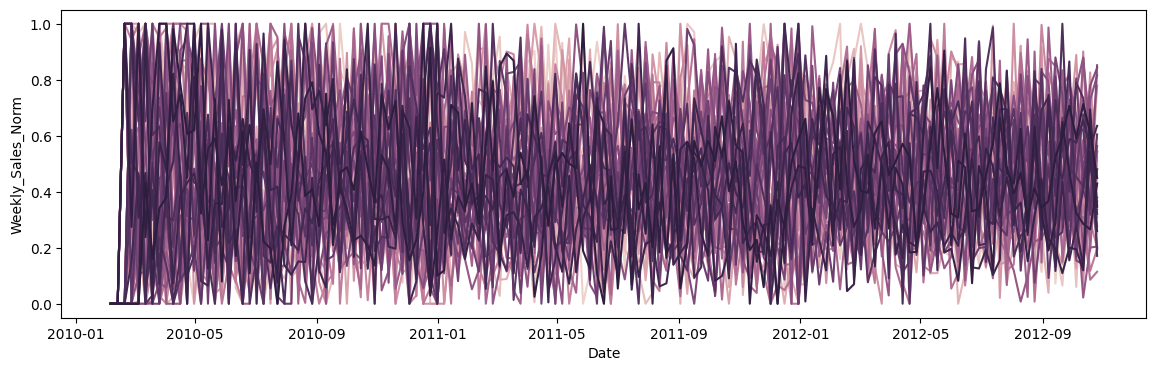

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 4))
sns.lineplot(data=df_model, x=df_model['Date'], y=df_model['Weekly_Sales_Norm'], hue=df_model['Store'], legend=False, estimator="mean")

In [5]:
"""from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_model["Store_enc"] = label_encoder.fit_transform(df_model['Store'])
df_model = df_model.drop(columns=['Store'])"""

'from sklearn.preprocessing import LabelEncoder\n\nlabel_encoder = LabelEncoder()\ndf_model["Store_enc"] = label_encoder.fit_transform(df_model[\'Store\'])\ndf_model = df_model.drop(columns=[\'Store\'])'

In [18]:
df_model.to_csv("../data/walmart_ml_data.csv", index=False)